In [293]:
import numpy as np
import pandas as pd
from metadata import data_type
from src.pipe_store import (
    data_loader,
    date_parser,
    clean_string_strip,
    set_data_types,
    sort_values_per_client,
    datetime2int,
    one_hot_encoder,
    label_encoder,
    combine_churns,
    feature_scaler,
    df_train_test_split,
    summerize_client_behaviour,
)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [173]:
data_path = '/Users/Danial/Downloads/assesment_file2_churn.csv'
df = (
    data_loader(data_path, parse_dates=['MONTH_PERIOD'], date_parser=date_parser)
    .pipe(set_data_types, data_type) # optimize space & df size
    .pipe(clean_string_strip, 'AGE_CLASS', 'HOMEBANK_COLOUR', 'LOYALITY')
    .pipe(combine_churns, dtype='int8')
    .pipe(sort_values_per_client, 'MONTH_PERIOD')
)

Step: data_loader | Shape: (100056, 28) | Computation Time: 0.561409s
Step: data_loader | Shape: (100056, 28) | Computation Time: 0.561409s
Step: data_loader | Shape: (100056, 28) | Computation Time: 0.561409s
Step: data_loader | Shape: (100056, 28) | Computation Time: 0.561409s
Step: data_loader | Shape: (100056, 28) | Computation Time: 0.561409s
Step: data_loader | Shape: (100056, 28) | Computation Time: 0.561409s
Step: data_loader | Shape: (100056, 28) | Computation Time: 0.561409s
Step: data_loader | Shape: (100056, 28) | Computation Time: 0.561409s
Step: data_loader | Shape: (100056, 28) | Computation Time: 0.561409s
Step: data_loader | Shape: (100056, 28) | Computation Time: 0.561409s
Step: data_loader | Shape: (100056, 28) | Computation Time: 0.561409s
Step: data_loader | Shape: (100056, 28) | Computation Time: 0.561409s
Step: set_data_types | Shape: (100056, 28) | Computation Time: 0.129184s
Step: set_data_types | Shape: (100056, 28) | Computation Time: 0.129184s
Step: set_data

# Problem Formulation

Lets see how much information exist in the data set


In this assessment case a customer is considered to have churned in a given month if either CHURNED_IND or COMMERCIALLY_CHURNED are set to value 1.

### Exploratory Data Analysis (EDA)

In [28]:
from src.feature_selection import total_variable_variances, variable_variances_per_client
var_matrix = variable_variances_per_client(df)
var_matrix

,PAYMENT_IND,SAVING_IND,INVESTMENTS_IND,LENDING_IND,MORTGAGE_IND,INSURANCE_LIFE_IND,INSURANCE_NONLIFE_IND,CROSS_SELL_SCORE,PACKAGE_IND,CREDIT_CLASS,DEBIT_CLASS,BUSINESS_VOLUME_CLASS,INVESTED_CAPITAL_CLASS,SAVINGS_CAPITAL_CLASS,MIN_FEED_CLASS,REVENUES_CLASS,PAYMENT_ACTIVITIES_CODE,TARGET,Record_Count,COMBINED_CHURN
6849612538,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.04,0.0,0.0,0.00
8434703737,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.04,0.00,0.0,0.0,0.00
5465847147,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.22,0.17,0.0,0.0,0.00
6376945954,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.08,0.00,0.00,4.98,0.25,0.0,0.0,0.00
2310295193,0.00,0.00,0.0,0.00,0.0,0.0,0.04,0.04,0.00,0.11,0.00,0.00,0.00,0.00,0.23,0.04,0.04,0.0,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9386078012,0.24,0.24,0.0,0.24,0.0,0.0,0.00,2.20,0.24,4.48,0.32,12.98,0.00,16.30,5.52,1.12,3.17,0.0,0.0,0.24
6038537607,0.25,0.25,0.0,0.00,0.0,0.0,0.00,1.01,0.00,1.01,0.25,4.61,0.00,2.28,0.23,0.51,0.00,0.0,0.0,0.25
2279322201,0.23,0.00,0.0,0.00,0.0,0.0,0.00,0.23,0.00,0.93,0.23,6.17,0.00,0.00,0.20,0.04,0.22,0.0,0.0,0.23
107886320,0.04,0.04,0.0,0.00,0.0,0.0,0.00,0.17,0.00,1.50,0.04,2.67,0.00,3.38,0.00,0.24,0.08,0.0,0.0,0.04


In [ ]:
var_matrix.mean().sort_values(ascending=False)

In [ ]:
# total_variable_variances(df, top=6, include_label=False)

'Record_Count' & 'TARGET' should be discarded from the data set

## Some remarks over the data

* Why to summerize the data:
    * The dynamic of client behaviours is rather slow (as to the variances). Thus we can account for the final value of each variable and the most recent changes (past 6 months) in the variable. This is to capture the latest state change in the variables close to the potential churn.

    * This corrects for potential inconsistency in subscription start time is important to be taken 
    
* To prevent potential bias in the dataset we have removed the client that either rejoin or rechurn 

* Column 'CHURNED_IND' is summerized to churn_event and the time at which churn occurs to churn_time.

* If client is not churned during the 24 months churn_time is assumed to be an arbitrary date, e.g. 2013-01-01.

In [294]:
horizon = 6 # Time horizon (Even number) to find dominant recent past states per column

df_sum = (df
    .drop(['TARGET', 'Record_Count'], axis=1)
    .pipe(summerize_client_behaviour, churn_col='CHURNED_IND', horizon=6)
    .pipe(set_data_types, {'churn_event':'float16'})
)

Step: set_data_types | Shape: (4124, 49) | Computation Time: 0.000691s
Step: set_data_types | Shape: (4124, 49) | Computation Time: 0.000691s
Step: set_data_types | Shape: (4124, 49) | Computation Time: 0.000691s
Step: set_data_types | Shape: (4124, 49) | Computation Time: 0.000691s
Step: set_data_types | Shape: (4124, 49) | Computation Time: 0.000691s
Step: set_data_types | Shape: (4124, 49) | Computation Time: 0.000691s
Step: set_data_types | Shape: (4124, 49) | Computation Time: 0.000691s
Step: set_data_types | Shape: (4124, 49) | Computation Time: 0.000691s
Step: set_data_types | Shape: (4124, 49) | Computation Time: 0.000691s
Step: set_data_types | Shape: (4124, 49) | Computation Time: 0.000691s
Step: set_data_types | Shape: (4124, 49) | Computation Time: 0.000691s
Step: set_data_types | Shape: (4124, 49) | Computation Time: 0.000691s
Step: set_data_types | Shape: (4124, 49) | Computation Time: 0.000691s
Step: set_data_types | Shape: (4124, 49) | Computation Time: 0.000691s
Step: 

Number of clients that rejoined [churn -> active]: 24
Number of clients with rechurned [active -> churn -> active]: 21


In [291]:
print('Class balance', dict(df_sum.churn_event.value_counts()))
res = dict(df_sum.churn_event.value_counts(normalize=True).round(4) * 100)
print(f'Class balance in % {res}')

Class balance {0.0: 3635, 1.0: 489}
Class balance in % {0.0: 88.14, 1.0: 11.86}


# Missing Values
Variables with missing values are: ACCOUNTMODEL, AGE_CLASS, HOMEBANK_COLOUR, LOYALITY

### Type of missingness:

In practice, domain experts or data managers can better argue on the type of the missingness. 

Missing Completely at Random (MCAR)-> random sampling from variable distribution

Missing at Random (MAR)-> random sampling from variable distribution or predict missing class via Logistic Regression

Missing not at Random (MNAR): Should not be imputed

### Adopted Strategy

Consider all the missingess as MNAR and proceed with feature selection. Upon importance of the variable with missigness or the missing categories we can come back and adopt another strategy 

In [34]:
from src.eda import top_columns_with_missingness
top_columns_with_missingness(df)

LOYALITY           23.009115
HOMEBANK_COLOUR    15.054569
ACCOUNTMODEL        7.009075
AGE_CLASS           5.289038
dtype: float64

In [35]:
top_columns_with_missingness(df_sum)

LOYALITY           23.327658
HOMEBANK_COLOUR    15.446363
ACCOUNTMODEL        1.775724
dtype: float64

In [ ]:
df_sum = df_sum.fillna('Unknown')

In [ ]:
# df_sum.info()

AGE_CLASS columns has more missing value than reported due to "Leeftijd_onbekend" label which.

# Feature Selection

From previous section we know to drop: 'Record_Count', 'TARGET'

### Time-to-Event [Kaplan-Meier] curves:

To estimate the retention curves, we use the Kaplan-Meier Estimate, definedas 

$$ \hat R(t) = \prod_{t_i \, <\, t} \frac{n_i - d_i}{n_i}$$

where $d_i$ are the number of churn events at time $t$ and $n_i$ is the number of clients at risk of churn just prior to time $t$

In [295]:
df_t2e = (
    df_sum
    .pipe(datetime2int, 'churn_time')
    .fillna('unknown')
)

Step: datetime2int | Shape: (4124, 49) | Computation Time: 0.516273s
Step: datetime2int | Shape: (4124, 49) | Computation Time: 0.516273s
Step: datetime2int | Shape: (4124, 49) | Computation Time: 0.516273s
Step: datetime2int | Shape: (4124, 49) | Computation Time: 0.516273s
Step: datetime2int | Shape: (4124, 49) | Computation Time: 0.516273s
Step: datetime2int | Shape: (4124, 49) | Computation Time: 0.516273s
Step: datetime2int | Shape: (4124, 49) | Computation Time: 0.516273s
Step: datetime2int | Shape: (4124, 49) | Computation Time: 0.516273s
Step: datetime2int | Shape: (4124, 49) | Computation Time: 0.516273s
Step: datetime2int | Shape: (4124, 49) | Computation Time: 0.516273s
Step: datetime2int | Shape: (4124, 49) | Computation Time: 0.516273s
Step: datetime2int | Shape: (4124, 49) | Computation Time: 0.516273s
Step: datetime2int | Shape: (4124, 49) | Computation Time: 0.516273s
Step: datetime2int | Shape: (4124, 49) | Computation Time: 0.516273s
Step: datetime2int | Shape: (4124,

In [297]:
df_train, df_test = (
    df_t2e.pipe(df_train_test_split, test_size=0.25)
)

In [264]:
df_train.churn_event.value_counts()
# df_test.churn_event.value_counts()

0.0    2733
1.0     356
Name: churn_event, dtype: int64

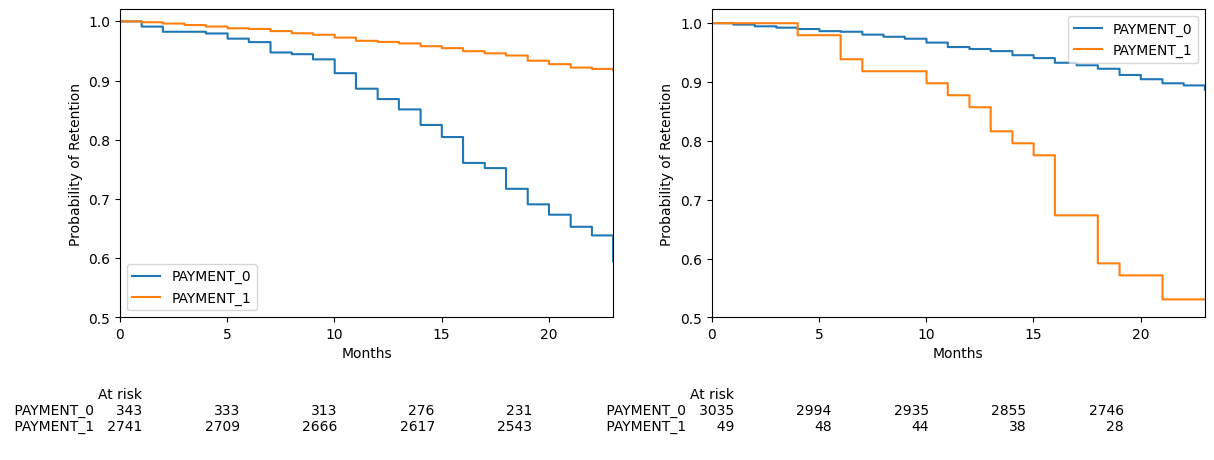

In [325]:
import matplotlib.pyplot as plt
from src.eda import plot_km_churn_risk
from lifelines import KaplanMeierFitter
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
# 'INSURANCE_LIFE_IND', 'INSURANCE_NONLIFE_IND', MORTGAGE_IND', 'PACKAGE_IND', 'INVESTMENTS_IND', 'LENDING_IND', 'SAVING_IND', 'PAYMENT_INDP
plot_km_churn_risk(df_train, 'PAYMENT_IND', ax=ax[0], estimator=KaplanMeierFitter, at_risk=True)
plot_km_churn_risk(df_train, 'PAYMENT_IND' + '_CHANGED', ax=ax[1], estimator=KaplanMeierFitter, at_risk=True)
# 'SAVING_IND', 'SAVING_IND_CHANGED','PAYMENT_IND', 'PAYMENT_IND_CHANGED'

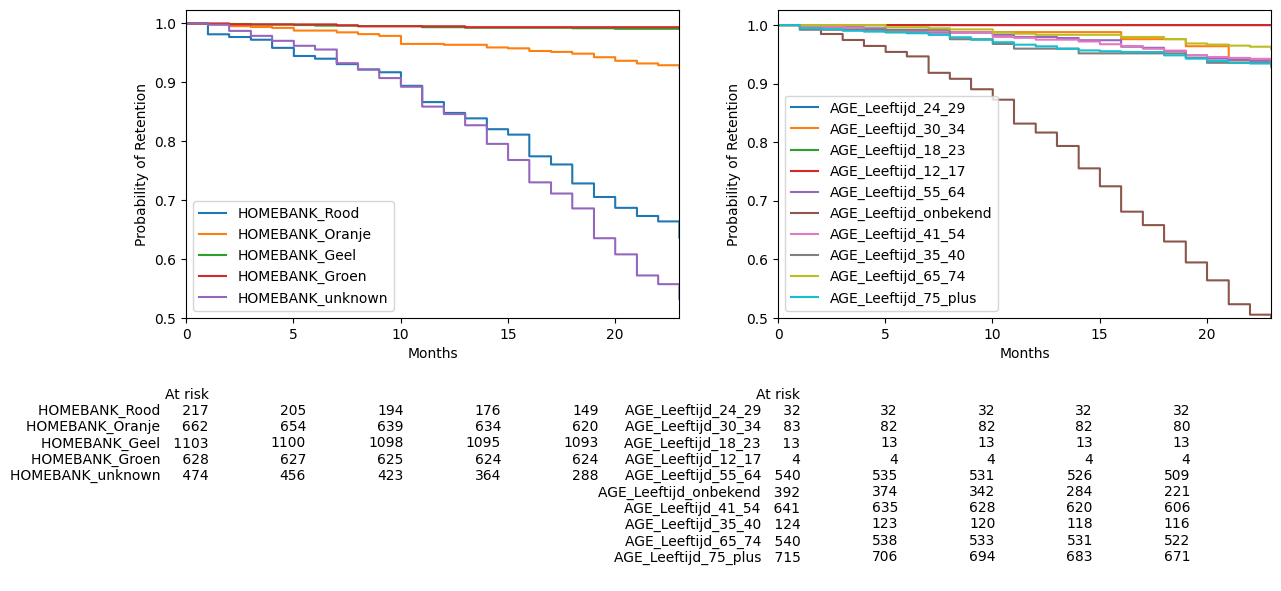

In [345]:
fig, ax = plt.subplots(1,2, figsize=(14, 4))
plot_km_churn_risk(df_train, 'HOMEBANK_COLOUR', ax=ax[0], estimator=KaplanMeierFitter, at_risk=True)
plot_km_churn_risk(df_train, 'AGE_CLASS', ax=ax[1], estimator=KaplanMeierFitter, at_risk=True)
# HOMEBANK_COLOUR_unknown, HOMEBANK_COLOUR_Rood, AGE_CLASS_Leeftijd_onbekend,

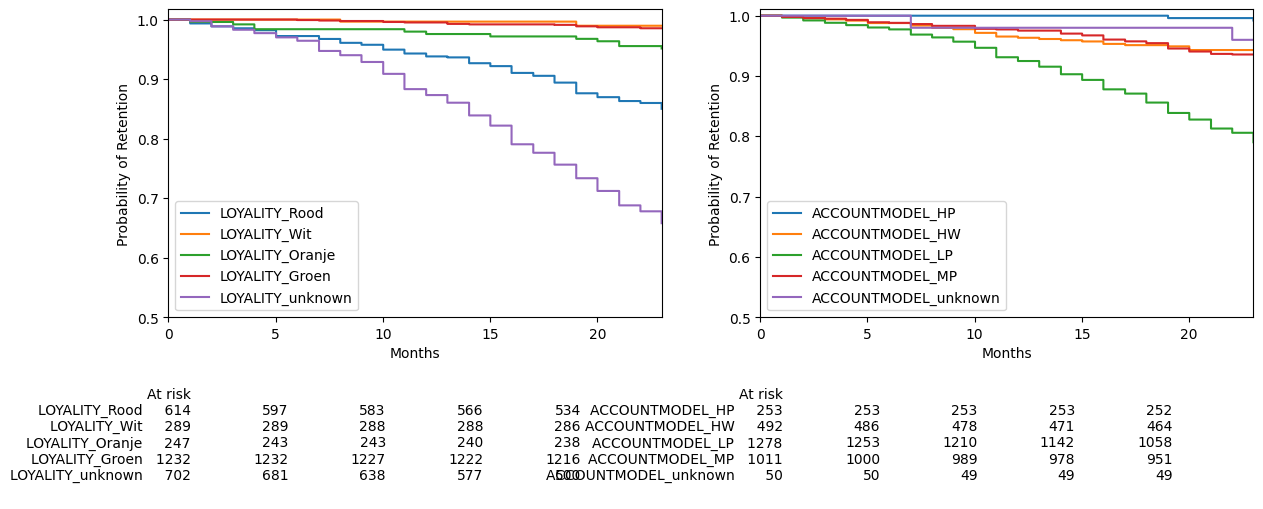

In [340]:
fig, ax = plt.subplots(1,2, figsize=(14, 4))
plot_km_churn_risk(df_train, 'LOYALITY', ax=ax[0], estimator=KaplanMeierFitter, at_risk=True)
plot_km_churn_risk(df_train, 'ACCOUNTMODEL', ax=ax[1], estimator=KaplanMeierFitter, at_risk=True)
# LOYALITY_unknown

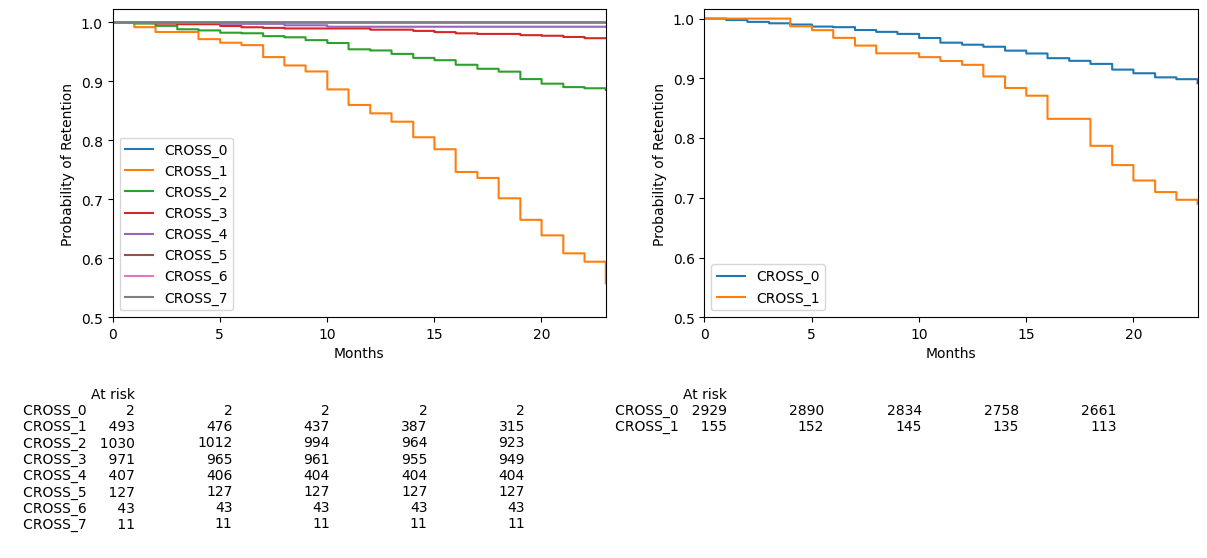

In [341]:
fig, ax = plt.subplots(1,2, figsize=(14, 4))
plot_km_churn_risk(df_train, 'CROSS_SELL_SCORE', ax=ax[0], estimator=KaplanMeierFitter, at_risk=True)
plot_km_churn_risk(df_train, 'CROSS_SELL_SCORE_CHANGED', ax=ax[1], estimator=KaplanMeierFitter, at_risk=True)
# CROSS_SELL_SCORE_1, CROSS_SELL_SCORE_CHANGED

In [347]:
# fig, ax = plt.subplots(1,2, figsize=(14, 4))
# plot_km_churn_risk(df_train, 'CREDIT_CLASS', ax=ax[0], estimator=KaplanMeierFitter, at_risk=True)
# plot_km_churn_risk(df_train, 'DEBIT_CLASS', ax=ax[1], estimator=KaplanMeierFitter, at_risk=True)
# CREDIT_CLASS_1, CREDIT_CLASS_0, DEBIT_CLASS_0

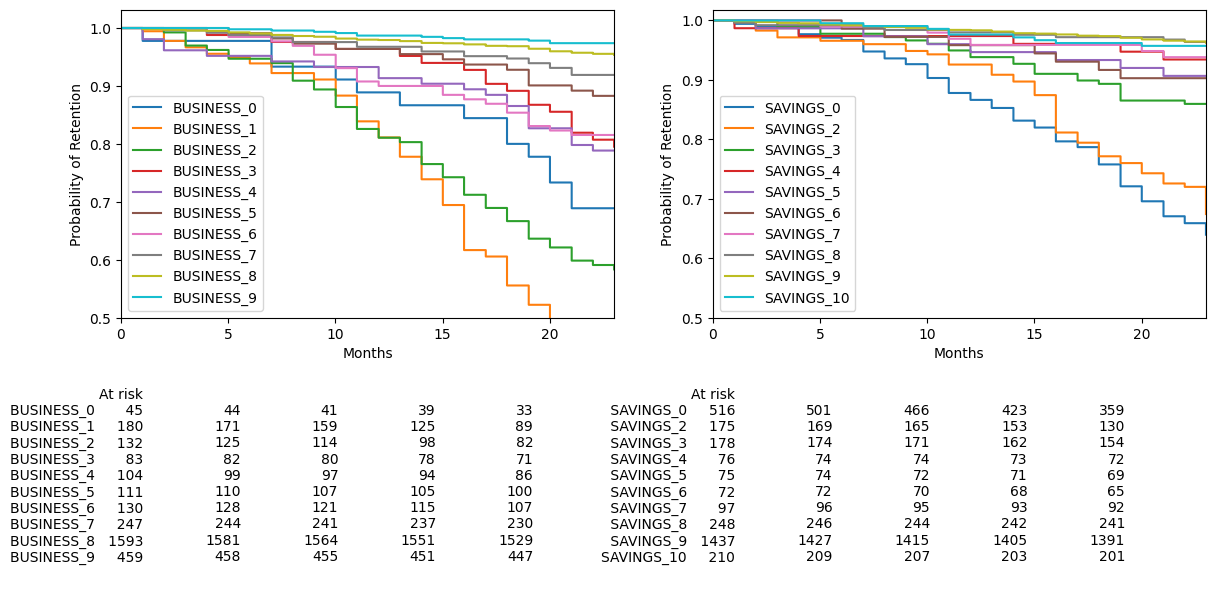

In [458]:
fig, ax = plt.subplots(1,2, figsize=(14, 4)) 
plot_km_churn_risk(df_train, 'BUSINESS_VOLUME_CLASS', ax=ax[0], estimator=KaplanMeierFitter, at_risk=True)
plot_km_churn_risk(df_train, 'SAVINGS_CAPITAL_CLASS', ax=ax[1], estimator=KaplanMeierFitter, at_risk=True)
# BUSINESS_VOLUME_CLASS_1 > BUSINESS_VOLUME_CLASS_2, SAVINGS_CAPITAL_CLASS_0 > SAVINGS_CAPITAL_CLASS_2

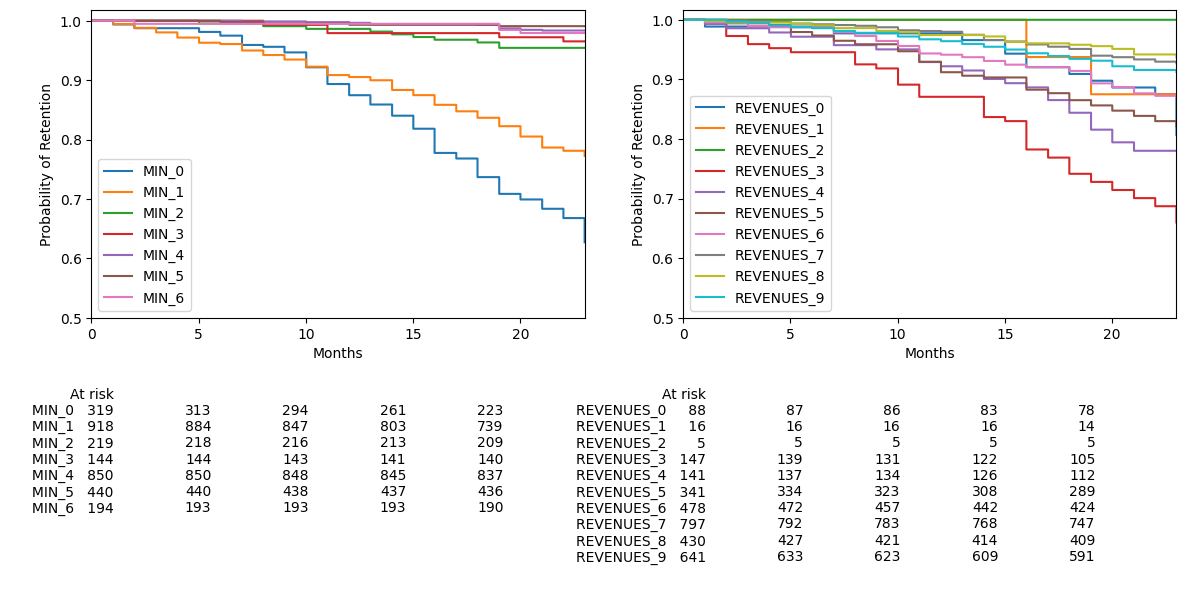

In [569]:
fig, ax = plt.subplots(1,2, figsize=(14, 4)) 
plot_km_churn_risk(df_train, 'MIN_FEED_CLASS', ax=ax[0], estimator=KaplanMeierFitter, at_risk=True)
plot_km_churn_risk(df_train, 'REVENUES_CLASS', ax=ax[1], estimator=KaplanMeierFitter, at_risk=True)
# MIN_FEED_CLASS_0, REVENUES_CLASS_3

In [396]:
# fig, ax = plt.subplots(1,2, figsize=(14, 4)) 
# plot_km_churn_risk(df_train, 'PAYMENT_ACTIVITIES_CODE', ax=ax[0], estimator=KaplanMeierFitter, at_risk=True)
# plot_km_churn_risk(df_train, 'ACCOUNTMODEL', ax=ax[1], estimator=KaplanMeierFitter, at_risk=True)
# ACCOUNTMODEL_LP, PAYMENT_ACTIVITIES_CODE_0

In [355]:
#'CLIENTGROUP' has ~40 categories. The promising ones were CLIENTGROUP_0101: 13%, CLIENTGROUP_0307:23 %,  CLIENTGROUP_0105: 42%
# fig, ax = plt.subplots(1,2, figsize=(14, 4)) 
# plot_km_churn_risk(df_train, 'INVESTED_CAPITAL_CLASS', ax=ax[0], estimator=KaplanMeierFitter, at_risk=True)

### Other Feature selection methods

In [415]:
from sklearn.model_selection import train_test_split

cat_cols = [
    'CREDIT_CLASS', 'DEBIT_CLASS', 'INVESTED_CAPITAL_CLASS', 'SAVINGS_CAPITAL_CLASS', 'MIN_FEED_CLASS', 'REVENUES_CLASS',
    'BUSINESS_VOLUME_CLASS', 'PAYMENT_ACTIVITIES_CODE', 'CLIENTGROUP', 'ACCOUNTMODEL', 'AGE_CLASS', 'HOMEBANK_COLOUR', 'LOYALITY']

X, y = (
    df_sum.copy(deep=True) 
    .fillna('unknown')
    .pipe(one_hot_encoder, *cat_cols, dtype='int8')
    # .pipe(label_encoder, 'CLIENTGROUP', 'ACCOUNTMODEL', 'AGE_CLASS', 'HOMEBANK_COLOUR', 'LOYALITY')
    .pipe(feature_scaler, 'CROSS_SELL_SCORE', scaler='Standard')
    .pipe(sklearn_adapter, label='churn_event')
)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Step: one_hot_encoder | Shape: (4124, 169) | Computation Time: 0.01884s
Step: one_hot_encoder | Shape: (4124, 169) | Computation Time: 0.01884s
Step: one_hot_encoder | Shape: (4124, 169) | Computation Time: 0.01884s
Step: one_hot_encoder | Shape: (4124, 169) | Computation Time: 0.01884s
Step: one_hot_encoder | Shape: (4124, 169) | Computation Time: 0.01884s
Step: one_hot_encoder | Shape: (4124, 169) | Computation Time: 0.01884s
Step: one_hot_encoder | Shape: (4124, 169) | Computation Time: 0.01884s
Step: one_hot_encoder | Shape: (4124, 169) | Computation Time: 0.01884s
Step: one_hot_encoder | Shape: (4124, 169) | Computation Time: 0.01884s
Step: one_hot_encoder | Shape: (4124, 169) | Computation Time: 0.01884s
Step: one_hot_encoder | Shape: (4124, 169) | Computation Time: 0.01884s
Step: one_hot_encoder | Shape: (4124, 169) | Computation Time: 0.01884s
Step: one_hot_encoder | Shape: (4124, 169) | Computation Time: 0.01884s
Step: one_hot_encoder | Shape: (4124, 169) | Computation Time: 0

In [416]:
y_test.value_counts()

0.0    906
1.0    125
Name: churn_event, dtype: int64

### Univariate Correlation

In [417]:
from src.feature_selection import select_kbest_features
col_drop = ['churn_time', 'id', 'CROSS_SELL_SCORE']
selected_cols = select_kbest_features(X_train.drop(col_drop, axis=1), y_train, k=20)
print(selected_cols)

['COMBINED_CHURN', 'PACKAGE_IND', 'CREDIT_CLASS_1', 'SAVINGS_CAPITAL_CLASS_0', 'SAVINGS_CAPITAL_CLASS_2', 'SAVINGS_CAPITAL_CLASS_9', 'MIN_FEED_CLASS_0', 'MIN_FEED_CLASS_1', 'MIN_FEED_CLASS_4', 'BUSINESS_VOLUME_CLASS_1', 'BUSINESS_VOLUME_CLASS_2', 'BUSINESS_VOLUME_CLASS_8', 'PAYMENT_ACTIVITIES_CODE_0', 'ACCOUNTMODEL_LP', 'AGE_CLASS_Leeftijd_onbekend', 'HOMEBANK_COLOUR_Geel', 'HOMEBANK_COLOUR_Rood', 'HOMEBANK_COLOUR_unknown', 'LOYALITY_Groen', 'LOYALITY_unknown']


In [418]:
from src.feature_selection import plot_corr_cat
corrs = plot_corr_cat(X_train[selected_cols], show_figure=False)

Correlations with signigicance < 0.05


### Model Based Feature Selection [Lasso]

* There are number of candidates, one of which is Lasso.

In [673]:
from sklearn.linear_model import Lasso
model = Lasso(alpha=0.003)
X_lasso = X_train.drop(['churn_time', 'id'], axis=1)
model.fit(X_lasso, y_train)
feat_selc = pd.DataFrame()
feat_selc['features'] = list(X_lasso.columns)
feat_selc['coeficient'] = model.coef_
# model.coef_

In [674]:
df_feat_lasso = feat_selc[feat_selc.coeficient.abs() > 0.0].sort_values(by='coeficient', ascending=True)
df_feat_lasso

,features,coeficient
75,REVENUES_CLASS_0,-0.047190
158,HOMEBANK_COLOUR_Oranje,-0.028307
16,CROSS_SELL_SCORE,-0.027749
156,HOMEBANK_COLOUR_Geel,-0.021947
93,BUSINESS_VOLUME_CLASS_8,-0.005200
18,SAVING_IND,-0.002058
23,REVENUES_CLASS_CHANGED,0.001715
69,MIN_FEED_CLASS_1,0.003476
0,SAVINGS_CAPITAL_CLASS_CHANGED,0.006044
165,LOYALITY_unknown,0.011062


In [675]:
print(len(set(df_feat_lasso.features.values)))
len(set(df_feat_lasso.features.values) & set(feature_selected_t2e))

19


8

## Multicolinearity

In [614]:
cat_cols = [
    'CREDIT_CLASS', 'DEBIT_CLASS', 'INVESTED_CAPITAL_CLASS', 'SAVINGS_CAPITAL_CLASS', 'MIN_FEED_CLASS', 'REVENUES_CLASS',
    'LOYALITY', 'BUSINESS_VOLUME_CLASS', 'PAYMENT_ACTIVITIES_CODE', 'CLIENTGROUP', 'ACCOUNTMODEL', 'AGE_CLASS', 'HOMEBANK_COLOUR']

df_corr = (
    df_train
    .pipe(one_hot_encoder, *cat_cols, dtype='int8')
    .pipe(feature_scaler, 'CROSS_SELL_SCORE', scaler='Standard')
)

Step: one_hot_encoder | Shape: (3084, 165) | Computation Time: 0.013769s
Step: one_hot_encoder | Shape: (3084, 165) | Computation Time: 0.013769s
Step: one_hot_encoder | Shape: (3084, 165) | Computation Time: 0.013769s
Step: one_hot_encoder | Shape: (3084, 165) | Computation Time: 0.013769s
Step: one_hot_encoder | Shape: (3084, 165) | Computation Time: 0.013769s
Step: one_hot_encoder | Shape: (3084, 165) | Computation Time: 0.013769s
Step: one_hot_encoder | Shape: (3084, 165) | Computation Time: 0.013769s
Step: one_hot_encoder | Shape: (3084, 165) | Computation Time: 0.013769s
Step: one_hot_encoder | Shape: (3084, 165) | Computation Time: 0.013769s
Step: one_hot_encoder | Shape: (3084, 165) | Computation Time: 0.013769s
Step: one_hot_encoder | Shape: (3084, 165) | Computation Time: 0.013769s
Step: one_hot_encoder | Shape: (3084, 165) | Computation Time: 0.013769s
Step: one_hot_encoder | Shape: (3084, 165) | Computation Time: 0.013769s
Step: one_hot_encoder | Shape: (3084, 165) | Comput

In [599]:
feature_selected_t2e = [
    'SAVING_IND', 'SAVING_IND_CHANGED','PAYMENT_IND', 'PAYMENT_IND_CHANGED', 'HOMEBANK_COLOUR_Rood', 'LOYALITY_unknown', 
    'AGE_CLASS_Leeftijd_onbekend', 'CROSS_SELL_SCORE_CHANGED', 'CREDIT_CLASS_1', 'CREDIT_CLASS_0', 'DEBIT_CLASS_0', 'BUSINESS_VOLUME_CLASS_1', # 'CROSS_SELL_SCORE_1', 
    'BUSINESS_VOLUME_CLASS_2', 'SAVINGS_CAPITAL_CLASS_0', 'SAVINGS_CAPITAL_CLASS_2',  'MIN_FEED_CLASS_0', 'REVENUES_CLASS_3',
    'PAYMENT_ACTIVITIES_CODE_0', 'CLIENTGROUP_0307', 'CLIENTGROUP_0105'
]
print('#Featue overlap with univariate correlation', len(set(selected_cols) & set(feature_selected_t2e)))
corrs = plot_corr_cat(df_corr[feature_selected_t2e], show_figure=False) 

#Featue overlap with univariate correlation 10
Correlations with signigicance < 0.05


In [466]:
from src.eda import plot_graph
top_corrs = corrs.sort_values(ascending=True)[0:11]
plot_graph(top_corrs)
top_corrs

CREDIT_CLASS_1           BUSINESS_VOLUME_CLASS_1         0.000000e+00
CREDIT_CLASS_0           DEBIT_CLASS_0                   0.000000e+00
LOYALITY_unknown         AGE_CLASS_Leeftijd_onbekend    6.238795e-258
CROSS_SELL_SCORE_1       MIN_FEED_CLASS_0               8.372329e-243
SAVING_IND_CHANGED       CROSS_SELL_SCORE_CHANGED       5.094683e-228
CROSS_SELL_SCORE_1       SAVINGS_CAPITAL_CLASS_0        3.403790e-220
PAYMENT_IND_CHANGED      CROSS_SELL_SCORE_CHANGED       2.251354e-203
SAVING_IND_CHANGED       PAYMENT_IND_CHANGED            4.336348e-188
MIN_FEED_CLASS_0         PAYMENT_ACTIVITIES_CODE_0      1.740213e-178
BUSINESS_VOLUME_CLASS_1  MIN_FEED_CLASS_0               1.789406e-178
                         CROSS_SELL_SCORE_1             6.763825e-174
dtype: float64

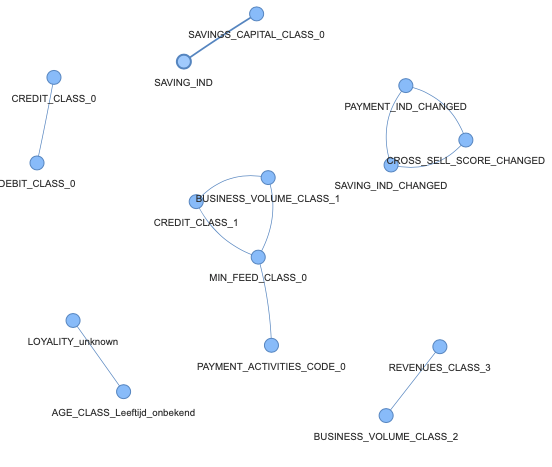

In [774]:
from IPython import display
display.Image("./graph/graph.png")
# DEBIT_CLASS_0 & CREDIT_CLASS_0
# CREDIT_CLASS_1 & BUSINESS_VOLUME_CLASS_1, MIN_FEED_CLASS_0
# LOYALITY_unknown & AGE_CLASS_Leeftijd_onbekend
# SAVING_IND & SAVING_CAPITAL_CLASS_0
# SAVING_INDEX_CHANGED & PAYMENT_IND_CHANGED & CROSS_SELL_SCORE_CHANGED

# Feature Engineering

# Seasonality [pattern in churn time]

In [ ]:
df_red[df_red.churn_event == 1]['churn_time'].value_counts().sort_index().plot.bar()


# Cox Proportional Hazard Model
Risk of churn can be modelled via the following method

$$ h(t|x)  = b_0(t) \exp \left ( \sum_{i=1}^n b_i (x_i -\bar x)) \right) $$


In [608]:
cat_cols = [
    'CREDIT_CLASS', 'DEBIT_CLASS', 'INVESTED_CAPITAL_CLASS', 'SAVINGS_CAPITAL_CLASS', 
    'MIN_FEED_CLASS', 'REVENUES_CLASS', 'PAYMENT_ACTIVITIES_CODE', 
    'CLIENTGROUP', 'ACCOUNTMODEL', 'AGE_CLASS', 'HOMEBANK_COLOUR', 'LOYALITY', ]     # 'CROSS_SELL_SCORE', 


cox_features = [
    'churn_event', 'churn_time', 
    # 'SAVING_IND', #'SAVINGS_CAPITAL_CLASS_0','SAVINGS_CAPITAL_CLASS_2',
    'PAYMENT_IND_CHANGED', #'CROSS_SELL_SCORE_CHANGED', #'SAVING_IND_CHANGED', 
    'PAYMENT_IND',
    'CREDIT_CLASS_0', #'DEBIT_CLASS_0',
    #'CREDIT_CLASS_1',  #
    # 'BUSINESS_VOLUME_CLASS_1', 
    'MIN_FEED_CLASS_0',
    'INVESTED_CAPITAL_CLASS_0',
    # 'REVENUES_CLASS_3', #
    'PAYMENT_ACTIVITIES_CODE_0', 
    # 'CLIENTGROUP_0105', 
    'CLIENTGROUP_0307',
    # 'CLIENTGROUP_0101', #
    'CROSS_SELL_SCORE',
    'LOYALITY_unknown', 
    'AGE_CLASS_Leeftijd_onbekend',
    'HOMEBANK_COLOUR_unknown', 
    'HOMEBANK_COLOUR_Rood',
    'LOYALITY_Rood', 
]

In [776]:
from lifelines import CoxPHFitter
cph = CoxPHFitter()
cph.fit(df_cox, duration_col='churn_time', event_col='churn_event')
cph.print_summary() 

<lifelines.CoxPHFitter: fitted with 3084 total observations, 2719 right-censored observations>
             duration col = 'churn_time'
                event col = 'churn_event'
      baseline estimation = breslow
   number of observations = 3084
number of events observed = 365
   partial log-likelihood = -2437.28
         time fit was run = 2022-10-24 20:55:07 UTC

---
                              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                           
SAVING_IND                   -0.45       0.64       0.12            -0.68            -0.22                 0.51                 0.80
PAYMENT_IND_CHANGED          -0.81       0.45       0.25            -1.30            -0.31                 0.27                 0.73
PAYMENT_IND                  -0.98       0.38       0.26            -1.50            -0.46                 0.22                 0.63
CREDIT_CLASS_0               -1.02       0.36       0.30            -1.60            -0.44                 0.20                 0.64
MIN_FEED_CLASS_0             -0.92       0.40       0.26            -1.43            -0.40                 0.24                 0.67
INVESTED_CAPITAL_CLASS_0      1.47       4.36       0.26             0.97             1.97                 2.64                 7.19
PAYMENT_ACTIVITIES_CODE_0     0.97       2.64       0.16             0.67             1.28                 1.94                 3.59
CLIENTGROUP_0307              0.98       2.67       0.27             0.46             1.50                 1.59                 4.50
CLIENTGROUP_0101              0.15       1.16       0.12            -0.09             0.38                 0.91                 1.46
LOYALITY_unknown              0.92       2.50       0.27             0.40             1.44                 1.49                 4.21
AGE_CLASS_Leeftijd_onbekend   0.75       2.11       0.32             0.13             1.37                 1.13                 3.93
HOMEBANK_COLOUR_unknown       1.16       3.20       0.31             0.55             1.78                 1.73                 5.91
HOMEBANK_COLOUR_Rood          1.57       4.80       0.20             1.17             1.97                 3.23                 7.15
LOYALITY_Rood                 0.75       2.13       0.24             0.28             1.23                 1.33                 3.41

                              cmp to     z      p   -log2(p)
covariate                                                   
SAVING_IND                      0.00 -3.86 <0.005      13.12
PAYMENT_IND_CHANGED             0.00 -3.21 <0.005       9.55
PAYMENT_IND                     0.00 -3.70 <0.005      12.20
CREDIT_CLASS_0                  0.00 -3.46 <0.005      10.84
MIN_FEED_CLASS_0                0.00 -3.49 <0.005      11.02
INVESTED_CAPITAL_CLASS_0        0.00  5.77 <0.005      26.88
PAYMENT_ACTIVITIES_CODE_0       0.00  6.20 <0.005      30.76
CLIENTGROUP_0307                0.00  3.69 <0.005      12.14
CLIENTGROUP_0101                0.00  1.21   0.23       2.15
LOYALITY_unknown                0.00  3.46 <0.005      10.84
AGE_CLASS_Leeftijd_onbekend     0.00  2.36   0.02       5.77
HOMEBANK_COLOUR_unknown         0.00  3.72 <0.005      12.28
HOMEBANK_COLOUR_Rood            0.00  7.74 <0.005      46.49
LOYALITY_Rood                   0.00  3.13 <0.005       9.15
---
Concordance = 0.90
Partial AIC = 4902.55
log-likelihood ratio test = 945.37 on 14 df
-log2(p) of ll-ratio test = 638.10

In [616]:
df_test_cox = (
    df_test
    .pipe(one_hot_encoder, *cat_cols, dtype='int8')
    .pipe(feature_scaler, 'CROSS_SELL_SCORE', scaler='Standard')
)

[autoreload of src.pipe_store failed: Traceback (most recent call last):
  File "/Users/Danial/.local/share/virtualenvs/ml-bnfBc1U0/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/Users/Danial/.local/share/virtualenvs/ml-bnfBc1U0/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 480, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/Danial/.local/share/virtualenvs/ml-bnfBc1U0/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 377, in update_generic
    update(a, b)
  File "/Users/Danial/.local/share/virtualenvs/ml-bnfBc1U0/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 289, in update_function
    setattr(old, name, getattr(new, name))
ValueError: one_hot_encoder() requires a code object with 1 free vars, not 0
]
Step: one_hot_encoder | Shape: (1040, 163) | Computation Time: 0.008935s
Step: one_hot_encoder | Shape: (1040, 163) |

In [733]:
from lifelines.utils import concordance_index
c_index = concordance_index(
    df_test_cox['churn_time'], 
    -cph.predict_partial_hazard(df_test_cox), 
    df_test_cox['churn_event'])
print(f'C-index for test data is{c_index * 100: .2f}%')

C-index for test data is 88.81%


In [773]:
inds_churn = df_test_cox.churn_event == 1
inds_no_churn = df_test_cox.churn_event == 0
pred_hazard = cph.predict_cumulative_hazard(df_test_cox).T
pred_surv = cph.predict_survival_function(df_test_cox).T

In [ ]:
sam_no_churn = preds[inds_no_churn].sample()
sam_churn = preds[inds_churn].sample()
fig, ax = plt.subplots(figsize=(6,4))
sam_no_churn.T.plot(ax=ax)
sam_churn.T.plot(ax=ax)
ax.legend(['Not Churned client', 'Churned client'])
ax.set_xlabel('Time(Month)')
ax.set_ylabel('Cumulative Hazard');

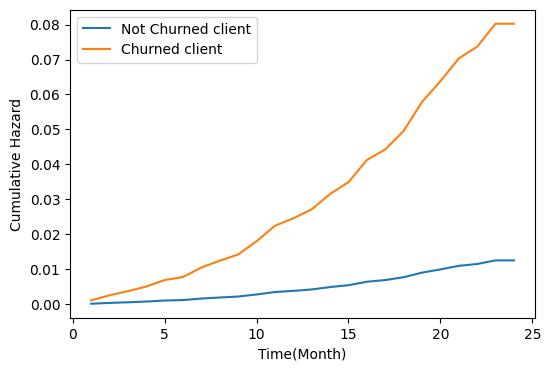

In [772]:
sam_no_churn = preds[inds_no_churn].sample()
sam_churn = preds[inds_churn].sample()
fig, ax = plt.subplots(figsize=(6,4))
sam_no_churn.T.plot(ax=ax)
sam_churn.T.plot(ax=ax)
ax.legend(['Not Churned client', 'Churned client'])
ax.set_xlabel('Time(Month)')
ax.set_ylabel('Cumulative Hazard');

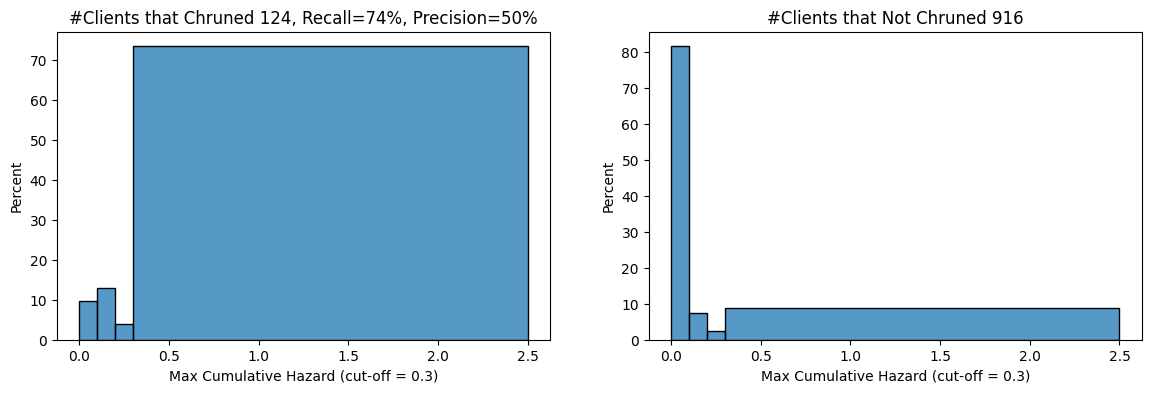

In [765]:
import seaborn as sns
fig, ax = plt.subplots(1, 2, figsize=(14,4))
sns.histplot(preds[inds_churn][24.0], stat='percent', ax=ax[0], bins=[0, .1, .2, .3,  2.5])
ax[0].set_title(f'#Clients that Chruned {len(preds[inds_churn])}, Recall=74%, Precision=50%')
ax[0].set_xlabel('Max Cumulative Hazard (cut-off = 0.3)')
sns.histplot(preds[inds_no_churn][24.0], stat='percent', ax=ax[1], bins=[0, .1, .2, .3,  2.5])
ax[1].set_title(f'#Clients that Not Chruned {len(preds[inds_no_churn])}')
ax[1].set_xlabel('Max Cumulative Hazard (cut-off = 0.3)');

# Classifier

In [122]:
from sklearn.model_selection import cross_validate, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from src.pipe_store import sklearn_adapter
random_state = 42

X, y = sklearn_adapter(df_cox, label='churn_event')
# regs = [ LogisticRegression(), RandomForestClassifier()]
X.drop('churn_time', axis=1, inplace=True)
regs =  [ LogisticRegression(), RandomForestClassifier(), GaussianNB()]

num_cols = ['CROSS_SELL_SCORE']
column_transformer_scaler = ColumnTransformer([
    ('Scaler', StandardScaler(), num_cols), 
], remainder='passthrough')

results = {}
for reg in regs:

    pipeline = Pipeline([
        ('scaler', column_transformer_scaler),
        ('Model', reg),
    ], verbose=False)

    kfs = KFold(n_splits=5, shuffle=True)
    # For the list of all metrics visit: https://scikit-learn.org/stable/modules/model_evaluation.html
    metrics = ['recall', 'precision', 'roc_auc', 'accuracy', 'f1'] 
    scores = cross_validate(pipeline, X, y, cv=kfs, scoring=metrics)
    # We will not use cross_val_score as it can only accept one metric
    # print(scores)
    reg_name = type(reg).__name__
    results[reg_name] = {key: round(np.mean(val), 3) for key, val in scores.items()}
pd.DataFrame(results).T

,fit_time,score_time,test_recall,test_precision,test_roc_auc,test_accuracy,test_f1
LogisticRegression,0.034,0.012,0.635,0.728,0.941,0.921,0.677
RandomForestClassifier,0.188,0.045,0.600,0.715,0.927,0.916,0.650
GaussianNB,0.005,0.011,0.780,0.548,0.930,0.889,0.642


In [124]:
from sklearn.model_selection import train_test_split
X, y = sklearn_adapter(df_cox, label='churn_event')
X.drop('churn_time', axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True)
clf = GaussianNB() # LogisticRegression() #GaussianNB()
pipeline = Pipeline([
    ('scaler', column_transformer_scaler),
    ('Model', clf),
], verbose=False)

pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('Scaler', StandardScaler(),
                                                  ['CROSS_SELL_SCORE'])])),
                ('Model', GaussianNB())])

# Model Evaluation

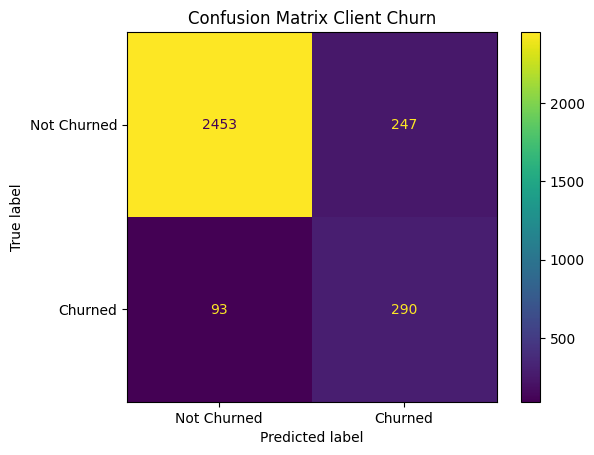

Precision/PPV := TP/(TP+FP):  0.6
Sensitivity/Recall/TPR := TP/(TP+FN):  0.84


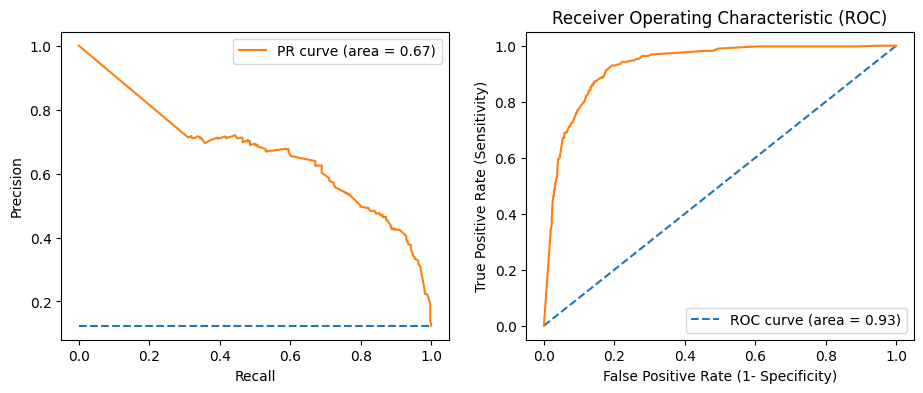

In [126]:
from src.model_evaluation import (
    plot_roc_curve,
    plot_confusion_matrix,
    plot_precision_recall_curve,
    print_scores,
)

from sklearn.model_selection import train_test_split
X, y = sklearn_adapter(df_cox, label='churn_event')
X.drop('churn_time', axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True)
clf = GaussianNB() # LogisticRegression() #GaussianNB()
pipeline = Pipeline([
    ('scaler', column_transformer_scaler),
    ('Model', clf),
], verbose=False)

pipeline.fit(X_train, y_train)

plot_confusion_matrix(pipeline, X_train, y_train)
fig, ax = plt.subplots(1,2, figsize=(11, 4))
plot_precision_recall_curve(pipeline, X_train, y_train, ax[0])
plot_roc_curve(pipeline, X_train, y_train, ax[1])
print_scores(pipeline, X_test, y_test)

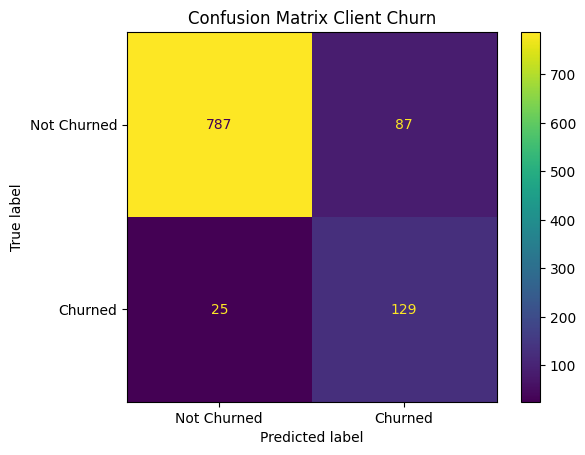

Precision/PPV := TP/(TP+FP):  0.6
Sensitivity/Recall/TPR := TP/(TP+FN):  0.84


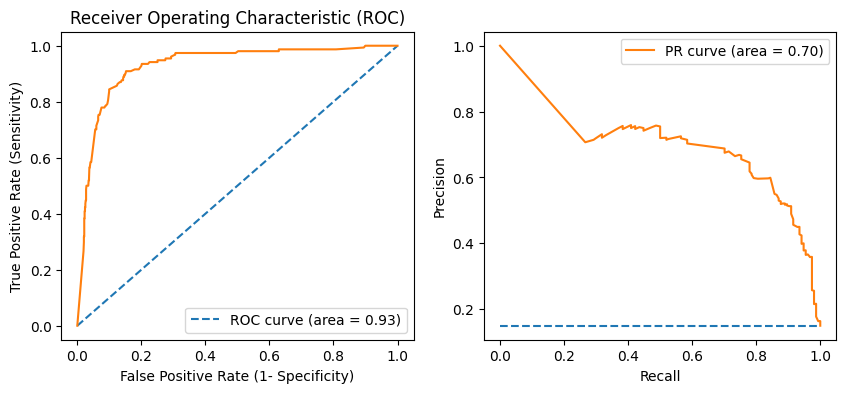

In [127]:
plot_confusion_matrix(pipeline, X_test, y_test)
print_scores(pipeline, X_test, y_test)
fig, ax = plt.subplots(1,2, figsize=(10, 4))
plot_roc_curve(pipeline, X_test, y_test, ax[0])
plot_precision_recall_curve(pipeline, X_test, y_test, ax[1])


In [ ]:
# from src.model_evaluation import plot_calibration
# plot_calibration(pipeline, X_test, y_test, n_bins=5, strategy='uniform')

In [ ]:

# forest_importances = pd.Series(rcf.feature_importances_, index=X.columns)

# fig, ax = plt.subplots()
# forest_importances.plot.bar( ax=ax)
# ax.set_title("Feature importances using MDI")
# ax.set_ylabel("Mean decrease in impurity")
# fig.tight_layout()

# Conclusion & Future directions:

* 

In [ ]:
X